# LSTM for Predicting Daily Return and Log Return (In-Sample Testing Only)

In [50]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense


In [ ]:

df = pd.read_csv("dataFiles/HINDUNILVR_cleaned.csv")

df = df[['Date','Open','Close']]
df['Date'] = pd.to_datetime(df['Date'], utc = True)
df.info()

df['LogReturn'] = np.log(df['Close'] / df['Close'].shift(1))
# df.dropna(inplace=True)
# df.reset_index(drop=True, inplace=True)
# df.head()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7384 entries, 0 to 7383
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype              
---  ------  --------------  -----              
 0   Date    7384 non-null   datetime64[ns, UTC]
 1   Open    7384 non-null   float64            
 2   Close   7384 non-null   float64            
dtypes: datetime64[ns, UTC](1), float64(2)
memory usage: 173.2 KB


,Date,Open,Close,DailyReturn,LogReturn
0,1996-01-01 18:30:00+00:00,34.623829,34.993568,0.010678,0.010622
1,1996-01-02 18:30:00+00:00,34.993582,34.786304,-0.005923,-0.005941
2,1996-01-03 18:30:00+00:00,34.733077,34.789097,0.000080,0.000080
3,1996-01-04 18:30:00+00:00,34.789098,34.733078,-0.001610,-0.001612
4,1996-01-07 18:30:00+00:00,34.733079,34.747086,0.000403,0.000403


In [52]:
scaler = MinMaxScaler()
scaled_daily = scaler.fit_transform(df[['DailyReturn']])
scaled_log = scaler.fit_transform(df[['LogReturn']])
scaled_normal = scaler.fit_transform(df[['Close']])


In [53]:
def create_dataset(series, look_back=5):
    X, y = [], []
    for i in range(len(series) - look_back):
        X.append(series[i:i + look_back])
        y.append(series[i + look_back])
    return np.array(X), np.array(y)

look_back = 5
X_daily, y_daily = create_dataset(scaled_daily, look_back)
X_log, y_log = create_dataset(scaled_log, look_back)
X_normal, y_normal = create_dataset(scaled_normal, look_back)

X_daily = X_daily.reshape((X_daily.shape[0], X_daily.shape[1], 1))
X_log = X_log.reshape((X_log.shape[0], X_log.shape[1], 1))
X_normal = X_normal.reshape((X_normal.shape[0], X_normal.shape[1], 1))


In [54]:
model_normal = Sequential()
model_normal.add(LSTM(50, input_shape=(look_back, 1)))
model_normal.add(Dense(1))
model_normal.compile(optimizer='adam', loss='mse')
model_normal.fit(X_normal, y_normal, epochs=30, batch_size=8, verbose=0)

/Users/ankuryadav/Downloads/data-iitm/.venv/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


231/231 ━━━━━━━━━━━━━━━━━━━━ 2s 722us/step


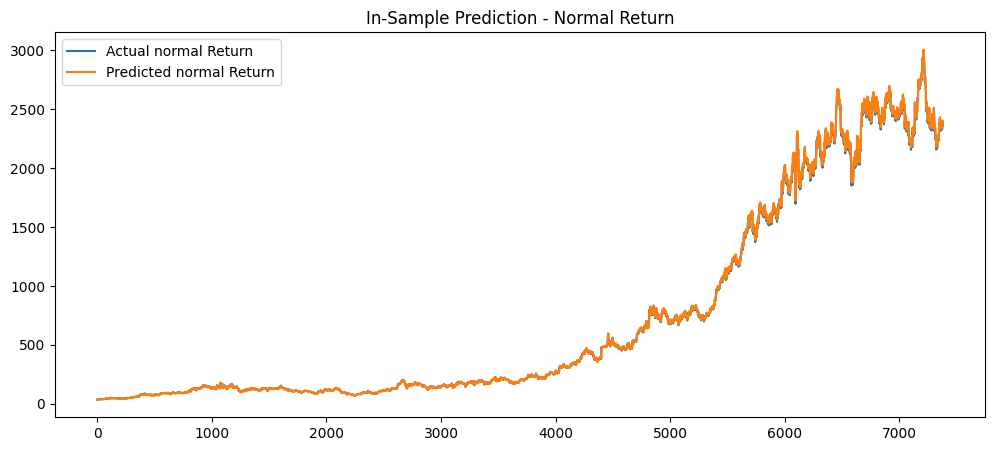

In [55]:
pred_normal = model_normal.predict(X_normal)
pred_normal_rescaled = scaler.inverse_transform(pred_normal)
actual_normal_rescaled = scaler.inverse_transform(y_normal.reshape(-1,1))

plt.figure(figsize=(12,5))
plt.plot(actual_normal_rescaled, label='Actual normal Return')
plt.plot(pred_normal_rescaled, label='Predicted normal Return')
plt.title('In-Sample Prediction - Normal Return')
plt.legend()
plt.show()

In [56]:
model_daily = Sequential()
model_daily.add(LSTM(50, input_shape=(look_back, 1)))
model_daily.add(Dense(1))
model_daily.compile(optimizer='adam', loss='mse')
model_daily.fit(X_daily, y_daily, epochs=30, batch_size=8, verbose=0)


/Users/ankuryadav/Downloads/data-iitm/.venv/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


231/231 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


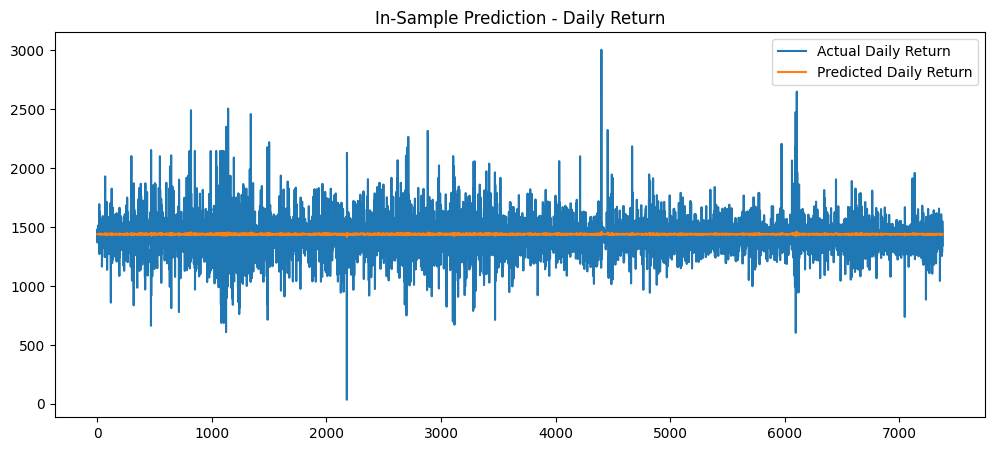

In [57]:
pred_daily = model_daily.predict(X_daily)
pred_daily_rescaled = scaler.inverse_transform(pred_daily)
actual_daily_rescaled = scaler.inverse_transform(y_daily.reshape(-1,1))

plt.figure(figsize=(12,5))
plt.plot(actual_daily_rescaled, label='Actual Daily Return')
plt.plot(pred_daily_rescaled, label='Predicted Daily Return')
plt.title('In-Sample Prediction - Daily Return')
plt.legend()
plt.show()


In [58]:
model_log = Sequential()
model_log.add(LSTM(50, input_shape=(look_back, 1)))
model_log.add(Dense(1))
model_log.compile(optimizer='adam', loss='mse')
model_log.fit(X_log, y_log, epochs=30, batch_size=8, verbose=0)


/Users/ankuryadav/Downloads/data-iitm/.venv/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


231/231 ━━━━━━━━━━━━━━━━━━━━ 0s 779us/step


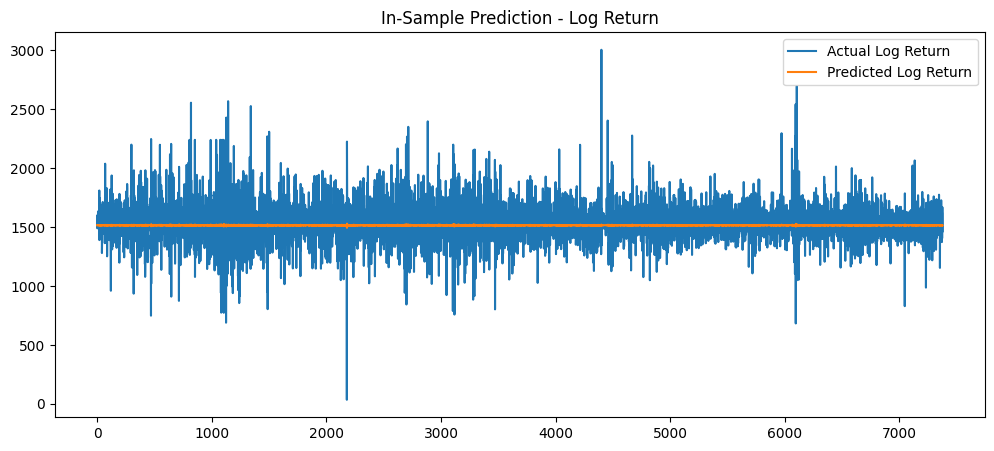

In [59]:
pred_log = model_log.predict(X_log)
pred_log_rescaled = scaler.inverse_transform(pred_log)
actual_log_rescaled = scaler.inverse_transform(y_log.reshape(-1,1))

plt.figure(figsize=(12,5))
plt.plot(actual_log_rescaled, label='Actual Log Return')
plt.plot(pred_log_rescaled, label='Predicted Log Return')
plt.title('In-Sample Prediction - Log Return')
plt.legend()
plt.show()


In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

def evaluate_metrics(actual, predicted, label=""):
    mse = mean_squared_error(actual, predicted)
    mae = mean_absolute_error(actual, predicted)
    rmse = np.sqrt(mse)
    mape = np.mean(np.abs((actual - predicted) / actual)) * 100
    r2 = r2_score(actual, predicted)
    
    print(f"--- {label} ---")
    print(f"MSE  : {mse:.6f}")
    print(f"MAE  : {mae:.6f}")
    print(f"RMSE : {rmse:.6f}")
    # print(f"MAPE : {mape:.2f}%")
    print(f"R^2  : {r2:.6f}")
    print()


# Evaluate Log Return
evaluate_metrics(actual_log_rescaled, pred_log_rescaled, label="Log Return")

evaluate_metrics(actual_normal_rescaled, pred_normal_rescaled, label="Closing Price")


--- Daily Return ---
MSE  : 27772.700721
MAE  : 117.778692
RMSE : 166.651435
R^2  : -0.013643

--- Log Return ---
MSE  : 27874.083127
MAE  : 116.728337
RMSE : 166.955333
R^2  : -0.020788

--- Normal Return ---
MSE  : 292.169921
MAE  : 8.634358
RMSE : 17.092979
R^2  : 0.999595



In [61]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

def create_sequences(series, look_back=5):
    X, y = [], []
    for i in range(len(series) - look_back):
        X.append(series[i:i+look_back])
        y.append(series[i+look_back])
    return np.array(X), np.array(y)

def build_lstm(input_shape):
    model = Sequential()
    model.add(LSTM(64, return_sequences=True, input_shape=input_shape))  # First LSTM layer (returns sequences)
    model.add(LSTM(32))                                                  # Second LSTM layer
    model.add(Dense(1))                                                  # Output layer
    model.compile(loss='mse', optimizer='adam')
    return model


In [62]:
# look_back_options = [3, 5, 10, 20, 30, 60]
# results = {}

# for lb in look_back_options:
#     # create sequences
#     X, y = create_sequences(series_scaled, look_back=lb)
#     X = X.reshape((X.shape[0], X.shape[1], 1))

#     # # train-test split
#     # X_train, X_test = X[:split], X[split:]
#     # y_train, y_test = y[:split], y[split:]

#     # build and train model
#     model = build_lstm((lb, 1))
#     model.fit(X_train, y_train, epochs=50, batch_size=16, verbose=0)

#     # predictions and metrics
#     y_pred = model.predict(X_test)
#     y_pred_inv = scaler.inverse_transform(y_pred)
#     y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1))

#     mse = mean_squared_error(y_test_inv, y_pred_inv)
#     results[lb] = mse

# # Show best
# best_lb = min(results, key=results.get)
# print("Best look_back:", best_lb)


Epoch 1/30


/Users/ankuryadav/Downloads/data-iitm/.venv/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


369/369 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0867
Epoch 2/30
369/369 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0807
Epoch 3/30
369/369 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0807
Epoch 4/30
369/369 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0833
Epoch 5/30
369/369 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0800
Epoch 6/30
369/369 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0815
Epoch 7/30
369/369 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0814
Epoch 8/30
369/369 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0833
Epoch 9/30
369/369 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0815
Epoch 10/30
369/369 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0826
Epoch 11/30
369/369 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0846
Epoch 12/30
369/369 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0833
Epoch 13/30
369/369 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0815
Epoch 14/30
369/369 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0809
Epoch 15/30
369/369 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0835


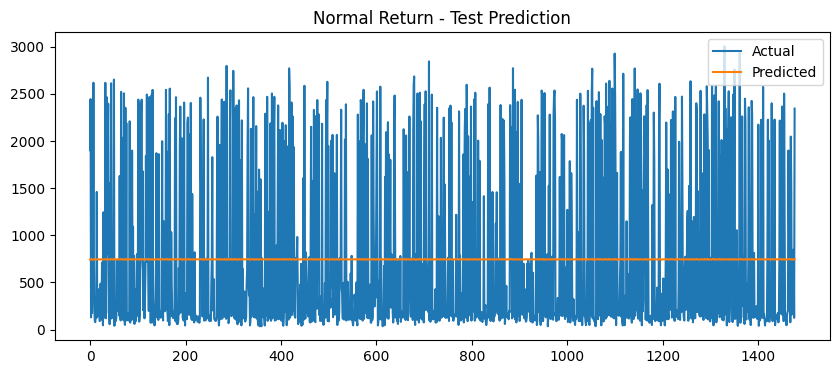

Epoch 1/30


/Users/ankuryadav/Downloads/data-iitm/.venv/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


369/369 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0231
Epoch 2/30
369/369 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0034
Epoch 3/30
369/369 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0035
Epoch 4/30
369/369 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0033
Epoch 5/30
369/369 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0036
Epoch 6/30
369/369 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0031
Epoch 7/30
369/369 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0032
Epoch 8/30
369/369 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0033
Epoch 9/30
369/369 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0032
Epoch 10/30
369/369 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0033
Epoch 11/30
369/369 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0035
Epoch 12/30
369/369 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0033
Epoch 13/30
369/369 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0033
Epoch 14/30
369/369 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0032
Epoch 15/30
369/369 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0031


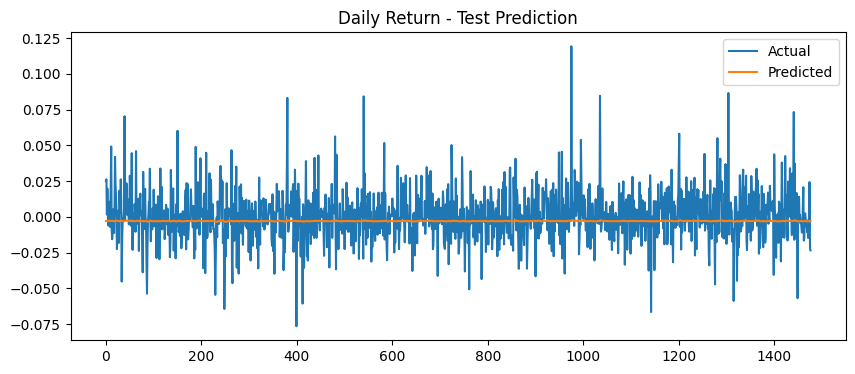

Epoch 1/30


/Users/ankuryadav/Downloads/data-iitm/.venv/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


369/369 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0294
Epoch 2/30
369/369 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0034
Epoch 3/30
369/369 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0031
Epoch 4/30
369/369 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0035
Epoch 5/30
369/369 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0033
Epoch 6/30
369/369 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0034
Epoch 7/30
369/369 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0033
Epoch 8/30
369/369 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0033
Epoch 9/30
369/369 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0034
Epoch 10/30
369/369 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0033
Epoch 11/30
369/369 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0034
Epoch 12/30
369/369 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0033
Epoch 13/30
369/369 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0034
Epoch 14/30
369/369 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0031
Epoch 15/30
369/369 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0031


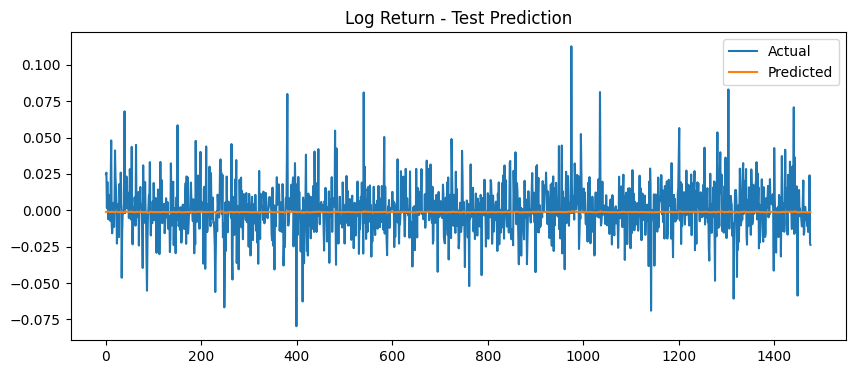

In [65]:
# look_back = 5
# look_back = 5
look_back = 5
results = {}

# Shuffle dataset for random train-test split
df_shuffled = df.sample(frac=1, random_state=42).reset_index(drop=True)
train_size = int(len(df_shuffled) * 0.8)

for label, column in {
    "Normal Return": "Close",
    "Daily Return": "DailyReturn",
    "Log Return": "LogReturn"
}.items():
    series = df_shuffled[[column]].dropna().values
    scaler = MinMaxScaler()
    series_scaled = scaler.fit_transform(series)

    X, y = create_sequences(series_scaled, look_back)
    X = X.reshape((X.shape[0], X.shape[1], 1))

    X_train, X_test = X[:train_size - look_back], X[train_size - look_back:]
    y_train, y_test = y[:train_size - look_back], y[train_size - look_back:]

    model = build_lstm((look_back, 1))
    model.fit(X_train, y_train, epochs=30, batch_size=16, verbose=1)


    y_pred = model.predict(X_test)
    y_pred_inv = scaler.inverse_transform(y_pred)
    y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1))

    mse = mean_squared_error(y_test_inv, y_pred_inv)
    mae = mean_absolute_error(y_test_inv, y_pred_inv)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test_inv, y_pred_inv)

    results[label] = {
        "MSE": mse,
        "MAE": mae,
        "RMSE": rmse,
        "R2": r2
    }

    plt.figure(figsize=(10, 4))
    plt.plot(y_test_inv, label="Actual")
    plt.plot(y_pred_inv, label="Predicted")
    plt.title(f"{label} - Test Prediction")
    plt.legend()
    plt.show()


In [64]:
for label, metrics in results.items():
    print(f"--- {label} ---")
    for k, v in metrics.items():
        print(f"{k:5}: {v:.4f}")
    print()


--- Normal Return ---
MSE  : 716875.8082
MAE  : 697.4433
RMSE : 846.6852
R2   : -0.0003

--- Daily Return ---
MSE  : 0.0003
MAE  : 0.0124
RMSE : 0.0173
R2   : -0.0082

--- Log Return ---
MSE  : 0.0003
MAE  : 0.0122
RMSE : 0.0172
R2   : -0.0004

